# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [0]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [0]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [1]:
!mkdir data
!cd data
!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat


--2020-06-14 05:12:36--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  13.9MB/s    in 15s     

2020-06-14 05:12:52 (11.2 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2020-06-14 05:12:52--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  13.4MB/s    in 4.6s    

2020-06-14 05:12:57 (13.4 MB/s) - ‘test_32x32.mat’ saved [64275384/64275384]

FINISHED --2020-06-14 05:12:57--
Total wall clock time: 21s
Downloaded: 2 files, 235M in

In [0]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [30]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [31]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [32]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for W1
Gradients are different at (0, 0). Analytic: 0.00005, Numeric: 0.00010


False

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [33]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for W1
Gradients are different at (0, 2). Analytic: 0.00776, Numeric: 0.00779


False

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [34]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [35]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 46.043743, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 46.024117, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 46.050432, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 46.034417, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 46.035961, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 46.033939, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 46.030750, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 46.020139, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 46.031302, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 46.029506, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 46.050336, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 46.034609, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 46.044107, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 46.036321, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 46.024699, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 46.0

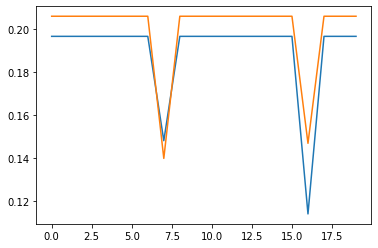

In [36]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [37]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 44.549100, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 45.851031, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 45.056935, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 45.878355, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 46.215203, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 45.398439, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 43.247208, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 46.185043, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 45.061693, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 45.036111, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 45.281789, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 45.518279, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 46.059851, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 46.552251, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 43.501499, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 46.2

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [38]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 45.992600, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 45.643870, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 45.730219, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 45.863197, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 45.863203, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 46.208059, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 44.763738, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 45.494205, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 45.878494, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 45.646483, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 44.260040, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 44.781636, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 44.724306, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 43.984005, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 44.411975, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 45.7

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [39]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 11.561905, Train accuracy: 0.266667, val accuracy: 0.133333
Loss: 11.531876, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 11.565293, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 11.306575, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 11.406156, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 11.205975, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 11.378238, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 10.826633, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 10.719910, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 10.984930, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 11.678652, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 11.346639, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 8.497311, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 8.741663, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 9.557402, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 8.34679

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [52]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 500, reg = 1e-2)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-2, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Loss: 11.456538, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 11.630753, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 10.941171, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 10.578908, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 10.325093, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 8.670694, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 7.624763, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 6.991997, Train accuracy: 0.400000, val accuracy: 0.066667
Loss: 9.084663, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 8.126909, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 10.484267, Train accuracy: 0.266667, val accuracy: 0.133333
Loss: 24.597558, Train accuracy: 0.400000, val accuracy: 0.066667
Loss: 8.435881, Train accuracy: 0.666667, val accuracy: 0.000000
Loss: 21.714541, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 19.626410, Train accuracy: 0.466667, val accuracy: 0.066667
Loss: 2.868328, 

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [63]:
# Let's train the best one-hidden-layer network we can

learning_rates = [3e-1, 2e-1, 1e-1, 1e-2, 1e-3]
reg_strength = [3e-2, 1e-2, 1e-3, 1e-4, 1e-5]
learning_rate_decay = 0.999
hidden_layer_size = [100, 128, 150, 200, 300, 500]
num_epochs = 20
batch_size = 64
data_size = min(100, len(train_X),len(train_y),len(val_X),len(val_y))

best_classifier = None
best_val_accuracy = None
best_reg_strength = None
best_learning_rate = None
best_hidden_layer_size = None


loss_history = []
train_history = []
val_history = []

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above

for lr in learning_rates:
    for rs in reg_strength:
        for hls in hidden_layer_size:
            print(f'learning_rate={lr}, reg_strength={rs}, hidden layer size={hls}')
    
            model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=hls, reg=rs)
            dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
            trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=lr, num_epochs=num_epochs, batch_size=batch_size, learning_rate_decay=learning_rate_decay)
            loss_hist, train_hist, val_hist = trainer.fit()
            accuracy = val_hist[-1]
            
            if not best_val_accuracy or accuracy > best_val_accuracy:
                best_classifier = model
                best_val_accuracy = accuracy
                loss_history = loss_hist
                train_history = train_hist
                val_history = val_hist
                best_reg_strength = rs
                best_learning_rate = lr
                best_hidden_layer_size = hls

print('best validation accuracy achieved: %f' % best_val_accuracy)
print('best learning rate: %f' % best_learning_rate)
print('best hidden layer size: %f' % best_hidden_layer_size)
print('best reg strength: %f' % best_reg_strength)

learning_rate=0.3, reg_strength=0.03, hidden layer size=100
Loss: 82.753980, Train accuracy: 0.160000, val accuracy: 0.230000
Loss: 82.096213, Train accuracy: 0.160000, val accuracy: 0.230000
Loss: 82.142509, Train accuracy: 0.160000, val accuracy: 0.230000
Loss: 80.864199, Train accuracy: 0.160000, val accuracy: 0.230000
Loss: 80.341650, Train accuracy: 0.220000, val accuracy: 0.180000
Loss: 78.876069, Train accuracy: 0.180000, val accuracy: 0.140000
Loss: 77.877121, Train accuracy: 0.180000, val accuracy: 0.140000
Loss: 80.007756, Train accuracy: 0.190000, val accuracy: 0.160000
Loss: 78.522221, Train accuracy: 0.210000, val accuracy: 0.180000
Loss: 74.440559, Train accuracy: 0.230000, val accuracy: 0.160000
Loss: 74.505173, Train accuracy: 0.260000, val accuracy: 0.080000
Loss: 71.373741, Train accuracy: 0.350000, val accuracy: 0.210000
Loss: 75.194414, Train accuracy: 0.360000, val accuracy: 0.190000
Loss: 69.828057, Train accuracy: 0.460000, val accuracy: 0.210000
Loss: 60.917271,

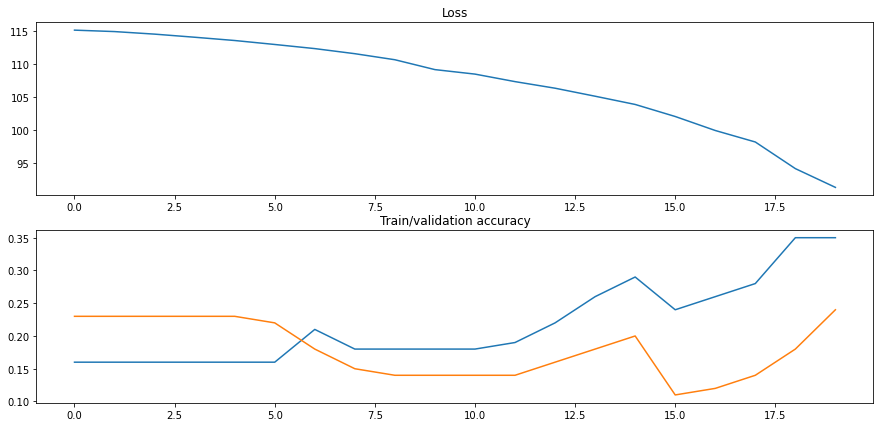

In [64]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [75]:
lr = 0.05
hls = 200
rs = 0.001
batch_size = 64
learning_rate_decay = 0.999
num_epochs = 40


model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = hls, reg = rs)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=lr, num_epochs=num_epochs, batch_size=batch_size, learning_rate_decay=learning_rate_decay)

loss_history, train_history, val_history = trainer.fit()
best_classifier = model


Loss: 81.891650, Train accuracy: 0.250667, val accuracy: 0.258000
Loss: 60.665989, Train accuracy: 0.499556, val accuracy: 0.489000
Loss: 40.966363, Train accuracy: 0.630111, val accuracy: 0.614000
Loss: 46.735629, Train accuracy: 0.659778, val accuracy: 0.628000
Loss: 51.743833, Train accuracy: 0.664667, val accuracy: 0.638000
Loss: 50.419013, Train accuracy: 0.703889, val accuracy: 0.686000
Loss: 45.494794, Train accuracy: 0.725111, val accuracy: 0.676000
Loss: 46.048956, Train accuracy: 0.734889, val accuracy: 0.688000
Loss: 33.615271, Train accuracy: 0.760222, val accuracy: 0.702000
Loss: 54.503657, Train accuracy: 0.714111, val accuracy: 0.678000
Loss: 39.886258, Train accuracy: 0.752222, val accuracy: 0.677000
Loss: 29.820330, Train accuracy: 0.758444, val accuracy: 0.695000
Loss: 39.217118, Train accuracy: 0.746667, val accuracy: 0.699000
Loss: 27.494473, Train accuracy: 0.748556, val accuracy: 0.700000
Loss: 23.164258, Train accuracy: 0.779222, val accuracy: 0.702000
Loss: 32.9

In [76]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.699000
